In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
import powerlaw
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def find_files(base_dir, file_ending):
    res = list()
    for root, dirs, files in os.walk(base_dir):
        if not root.endswith('/'):
            root += '/'
        res.extend([root + i for i in filter(lambda x: x.endswith(file_ending), files)])
    return sorted(res)

base_dir = '/home/fgeigl/navigability_of_networks/output/bias_link_ins'
net_files = filter(lambda x: 'bow_tie' not in x, find_files(base_dir,'.gt'))
print('Networks:', net_files)
debug = False
plots_dir = base_dir + '/network_property_plots/'
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)

Networks: ['/home/fgeigl/navigability_of_networks/output/bias_link_ins/daserste.gt/daserste.gt', '/home/fgeigl/navigability_of_networks/output/bias_link_ins/tvthek_orf.gt/tvthek_orf.gt', '/home/fgeigl/navigability_of_networks/output/bias_link_ins/wiki4schools.gt/wiki4schools.gt']


In [3]:
networks = dict()
ds_name_conv = {'daserste.gt':'DEM', 'tvthek_orf.gt':'ORF', 'wiki4schools.gt':'W4S'}
for i in net_files:
    print('\tload:', i.rsplit('/', 1)[-1])
    networks[ds_name_conv[i.rsplit('/',1)[-1]]] = load_graph(i)
print(networks)
    

{'ORF': <Graph object, directed, with 9799 vertices and 301844 edges at 0x7f4cd2d1d510>, 'W4S': <Graph object, directed, with 4051 vertices and 111795 edges at 0x7f4cd34ac390>, 'DEM': <Graph object, directed, with 70063 vertices and 3448513 edges at 0x7f4d13313050>}


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


<IPython.core.display.Javascript object>


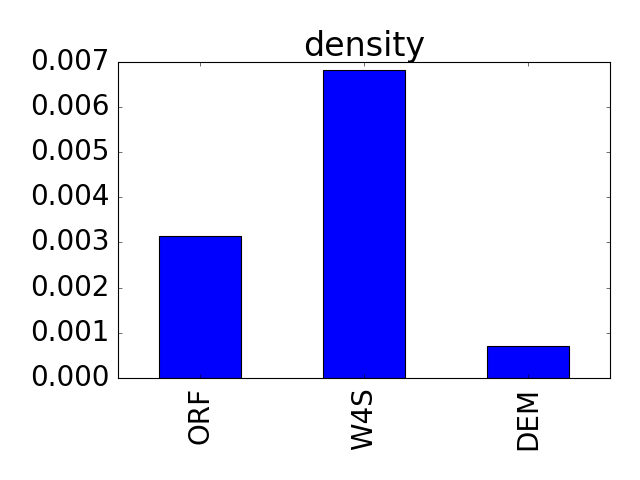

<IPython.core.display.Javascript object>


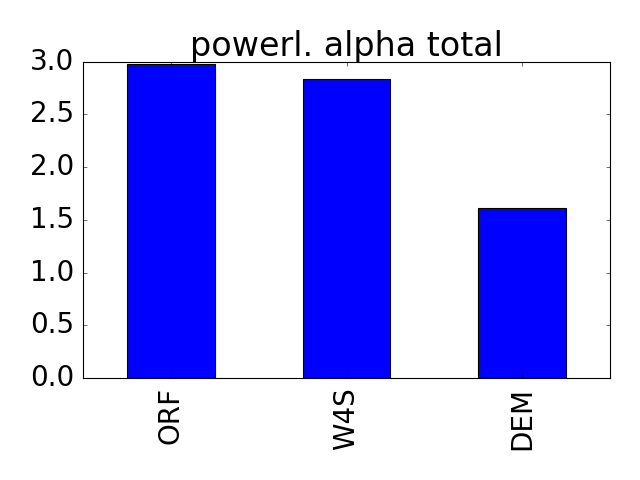

<IPython.core.display.Javascript object>


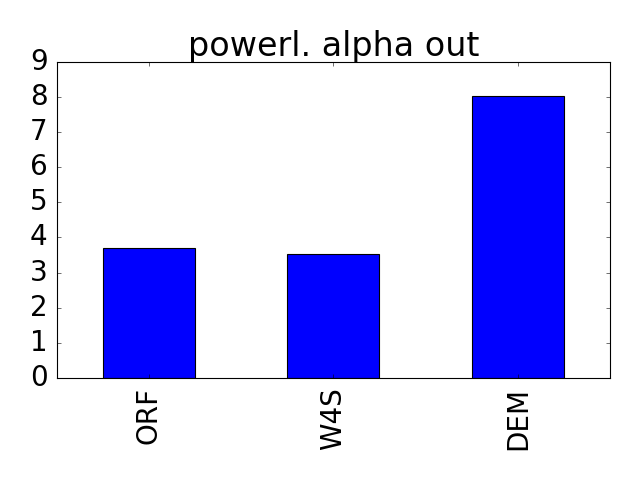

<IPython.core.display.Javascript object>


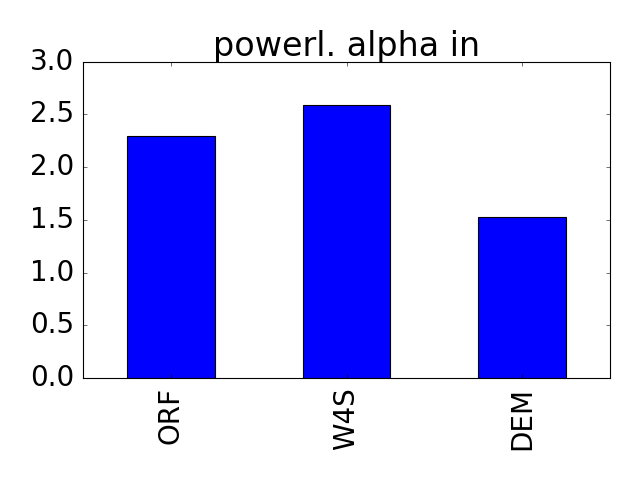

<IPython.core.display.Javascript object>


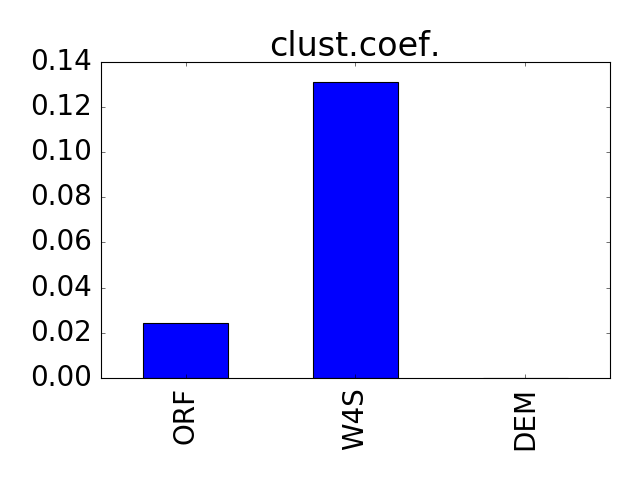

In [25]:
df = pd.DataFrame()
for ds, net in networks.iteritems():
    df.at['density', ds] = net.num_edges()/(net.num_vertices()*(net.num_vertices()-1))
    df.at['powerl. alpha total', ds] = powerlaw.Fit(net.degree_property_map('total').a, discrete=True).power_law.alpha
    df.at['powerl. alpha out', ds] = powerlaw.Fit(net.degree_property_map('out').a, discrete=True).power_law.alpha
    df.at['powerl. alpha in', ds] = powerlaw.Fit(net.degree_property_map('in').a, discrete=True).power_law.alpha
    df.at['clust.coef.', ds] = global_clustering(net)[0]

for jdx,idx in enumerate(df.index):
    fig, ax = plt.subplots()
    df.loc[idx].plot.bar(ax=ax, legend=False)
    plt.title(idx)
    plt.tight_layout()
    plt.show()

<IPython.core.display.Javascript object>


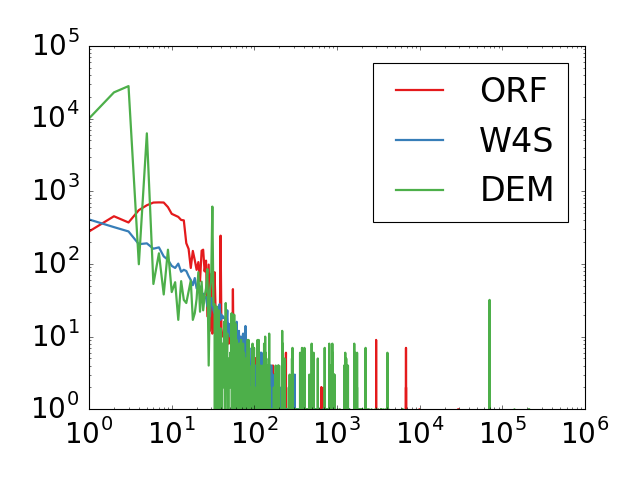

in


<IPython.core.display.Javascript object>


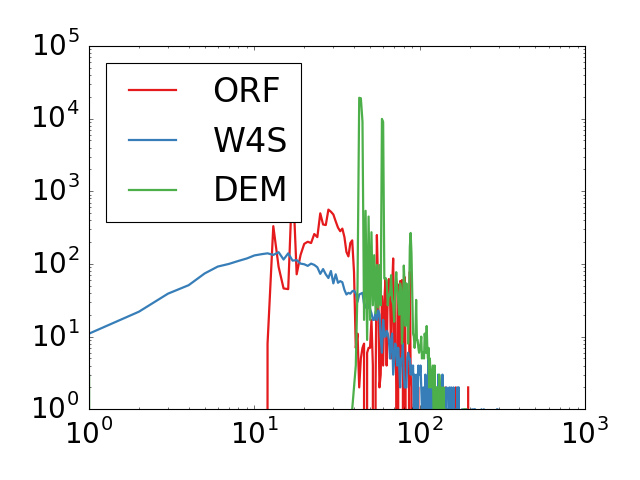

out


<IPython.core.display.Javascript object>


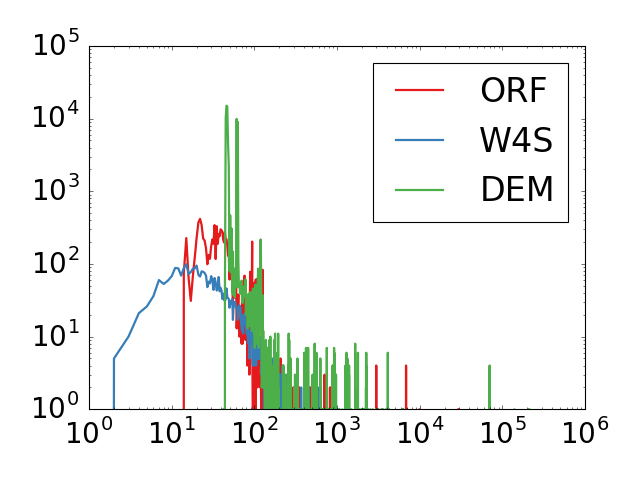

total


In [24]:
colors = ['#e41a1c','#377eb8','#4daf4a']
for d_type in ['in', 'out', 'total']:
    fig, ax = plt.subplots()
    print(d_type)
    for idx, (ds, net) in enumerate(networks.iteritems()):
        counts, bins = vertex_hist(net, d_type)
        ax.plot(bins[:-1], counts, label=ds, lw=2, c=colors[idx])
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    